### __4) Simple decision trees__ 

Can you do better than the k-NN baseline with decision trees?
- What accuracy can you achieve with a depth of 3?
- Plot the corresponding tree with graphviz
- Do you get better results if you reduce the number of dimensions with PCA first?

In [1]:
import matplotlib.image as mpimg
import glob
import numpy as np
import pandas as pd
import os
import tensorflow as tf 
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline      import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors     import KNeighborsClassifier
from sklearn.tree          import DecisionTreeClassifier
from IPython.display       import Markdown as md


In [2]:
data_dir = 'C:/Users/tgdreju4/OneDrive - Swisscom/EPFL/Notebooks/04ML/swissroads/'
my_dir = data_dir + 'test/'

Load the data from the npz file

In [3]:
with np.load(os.path.join('data',data_dir + 'train.npz'), allow_pickle=False) as data:
    train_data = dict(data.items())
    
with np.load(os.path.join('data', data_dir + 'test.npz'), allow_pickle=False) as data:
    test_data = dict(data.items())    

with np.load(os.path.join('data',data_dir + 'valid.npz'), allow_pickle=False) as data:
    valid_data = dict(data.items())    

class_names=['bike','car','motorcycle','other','truck','van']

# Create X/y arrays
X_tr = train_data['features']
X_te = test_data['features']
X_va = valid_data['features']
y_tr = train_data['labels']
y_te = test_data['labels']
y_va = valid_data['labels']
z_tr = train_data['files']
z_te = test_data['files']





#### What accuracy can you achieve with a depth of 3?

In [4]:
# Create decision tree
dt = DecisionTreeClassifier(criterion='gini', max_depth=3, random_state=0)
# Fit decision tree
dt.fit(X_tr, y_tr)
# Get score
dt.score(X_tr, y_tr)


0.725

__Result:__

> The decision tree with max_dept=3 correctly classifies: (see following list)

    

In [5]:
print('The accuracy with max_depth=3 for test  is {:.2f}%  ' .format(dt.score(X_te, y_te)) , 'with a shape of', X_te.shape)
print('The accuracy with max_depth=3 for valid is {:.2f}%  ' .format(dt.score(X_va, y_va)) , 'with a shape of', X_va.shape)
print('The accuracy with max_depth=3 for train is {:.2f}%  ' .format(dt.score(X_tr, y_tr)) , 'with a shape of', X_tr.shape)

The accuracy with max_depth=3 for test  is 0.72%   with a shape of (50, 2048)
The accuracy with max_depth=3 for valid is 0.72%   with a shape of (139, 2048)
The accuracy with max_depth=3 for train is 0.72%   with a shape of (280, 2048)


#### Plot the corresponding tree with graphviz

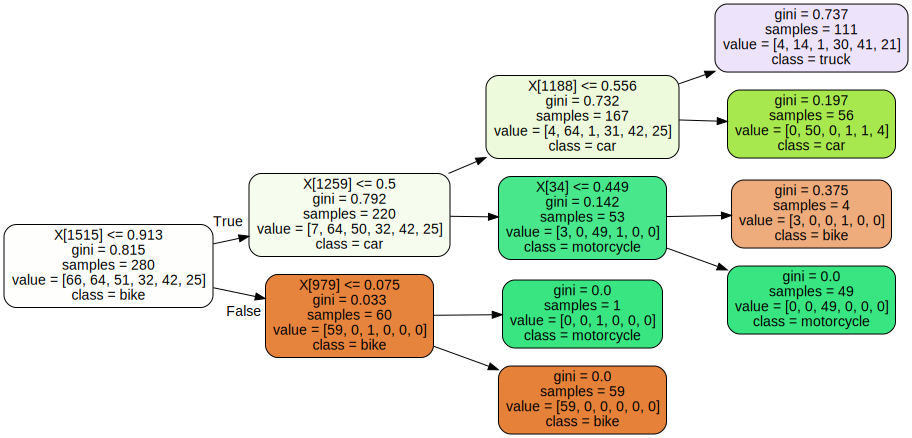

<Figure size 360x360 with 0 Axes>

In [6]:
import graphviz
from sklearn.tree import export_graphviz
# Export decision tree
fig = plt.figure(figsize=(5,5))
dot_data_2 = export_graphviz(dt, out_file=None,
                             class_names=['bike','car','motorcycle','other','truck','van'],
                             filled=True, rounded=True, proportion=False,rotate= True)
# Display it
graphviz.Source(dot_data_2)


#### Do you get better results if you reduce the number of dimensions with PCA first?

In [7]:
print('Shape of X_tr: ', X_tr.shape)
print('Shape of X_te: ', X_te.shape)

Shape of X_tr:  (280, 2048)
Shape of X_te:  (50, 2048)


In [8]:
from sklearn.decomposition import PCA
# Create PCA transformer
pca = PCA(n_components=50)

# Apply PCA
pca.fit(X_tr, y_tr);

# Project data onto the first x components
X_pca_tr = pca.fit_transform(X_tr)
X_pca_va = pca.transform(X_va)
X_pca_te = pca.transform(X_te)

print('Shape of X_pca_tr: ', X_pca_tr.shape)
print('Shape of X_pca_va: ', X_pca_va.shape)
print('Shape of X_pca_te: ', X_pca_te.shape)

Shape of X_pca_tr:  (280, 50)
Shape of X_pca_va:  (139, 50)
Shape of X_pca_te:  (50, 50)


#### Find the best max_depths

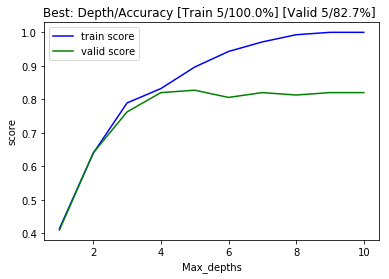

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

#Score results
train_results = []
valid_results = []

max_depths = np.linspace(1, 10, 10, endpoint=True) #Values between 1 and 10

for max_depth in max_depths: # Loop the depth values
    # Create decision tree
    dt = DecisionTreeClassifier(criterion='gini', max_depth=max_depth, random_state=0)
    dt.fit(X_pca_tr, y_tr)
    
    train_results.append(dt.score(X_pca_tr, y_tr))
    valid_results.append(dt.score(X_pca_va, y_va))
 

#Plot the result
# get the Index of the best value (+ 1 because it starts with 0)
best_depth = valid_results.index(max(valid_results)) + 1 

plt.plot(max_depths, train_results, 'blue', label='train score')
plt.plot(max_depths, valid_results, 'green', label='valid score')


plt.legend()
plt.title('Best: Depth/Accuracy [Train {}/{:.1f}%] [Valid {}/{:.1f}%] ' .format(best_depth, 100*max(train_results),
                                                                                best_depth, 100*max(valid_results))  )
plt.ylabel('score')
plt.xlabel('Max_depths')
plt.show()

__Result:__

> Yes, the results with PCA (principal component analysis) is much better. The best score with PCA reduced dimensions can be achieved with a max_depth of 6. This improves the accuracy of the validation set from 70 % to 83 %. I will now continue to create a decision tree with max_depth = 6 and reduced dimension and apply it to the test set.

In [10]:
# Create decision tree
dt_2 = DecisionTreeClassifier(criterion='gini', max_depth=6, random_state=0)

# Fit decision tree
dt_2.fit(X_pca_tr, y_tr)

X_pca_te = pca.transform(X_te)

# Get score
print('Accuracy Valid set {:.1f}%'.format (dt_2.score(X_pca_va, y_va)*100) )
print('Accuracy Test set  {:.1f}%'.format (dt_2.score(X_pca_te, y_te)*100) )

Accuracy Valid set 80.6%
Accuracy Test set  90.0%


#### collect results

In [11]:
# Load the pickle file
df = pd.read_csv(data_dir + 'data.csv', index_col=0)
df = df.append({
       'model':         'decision tree',
       'test accuracy': dt_2.score(X_pca_te, y_te)
            },ignore_index=True)  

df.to_csv(data_dir + 'data.csv')
# read all results from csv and print 
df = pd.read_csv(data_dir +  'data.csv', index_col=0)
df

,model,test accuracy
0,knn,0.84
1,decision tree,0.90
